# Nonlinear Counterfactual Generation using CEBRA Embedding and KDE
Code for generating nonlinear counterfactuals of non-responder to responder using CEBRA embeddings and Kernel Density Estimation (KDE).

# Load and Prepare Data
The DDIM latent space data (84x36) is reshaped for analysis.
Equal numbers of responders and non-responders (46 subjects) are selected.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load DDIM dataset of 23 responders and 61 non-responders 
# E-Field mapped on Center slice and coil angles y varies from 0 to 360 degrees
latent_vectors = np.load('84x36_latents.npy')

# Choose equal number of responders and non-responders (total 46)
latent_data = latent_vectors.reshape(84, 36, 4, 32, 32)[:46]

# Define and Fit CEBRA Model
CEBRA is used to reduce high-dimensional latent space into a 2D embedding.\
Visualize responders and non-responders in embedded space

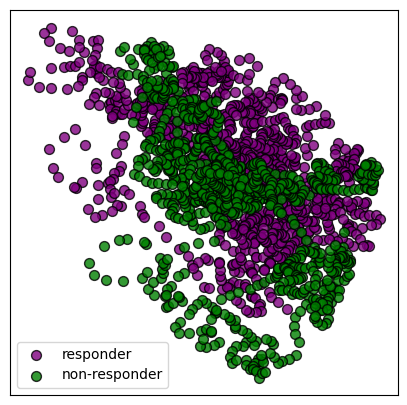

In [2]:
# Define and fit CEBRA model
import sklearn.linear_model
from cebra import CEBRA

# Set the seed for reproducibility
np.random.seed(42)

# Shuffle the subjects
idx = np.random.permutation(46)
shuffled_latent_data_46 = latent_data[idx]

n = 46*36
sel_latent = shuffled_latent_data_46.reshape(n, 4*32*32)

Z_data = sel_latent

max_iterations = 2000

cebra_model = CEBRA(
    model_architecture="offset1-model-mse",
    batch_size=512,
    learning_rate=1e-4,
    max_iterations=max_iterations,
    delta=10,
    conditional='delta',
    output_dimension=2,
    distance='euclidean',
    device="cuda_if_available",
    verbose=False,)
    
cebra_model.fit(Z_data)

shuffled_Z_data_cebra = cebra_model.transform(Z_data)

idx_r = np.argsort(idx)
Z_data_cebra_latents = shuffled_Z_data_cebra.reshape(46,36,shuffled_Z_data_cebra.shape[1])[idx_r]
Z_data_cebra = Z_data_cebra_latents.reshape(46*36,shuffled_Z_data_cebra.shape[1])    

# Visualize the CEBRA embeddings of responders and non-responders
fig = plt.figure(figsize=(5,5))
N = 23*36
plt.scatter(Z_data_cebra[:N,0], Z_data_cebra[:N,1], 
            c = 'purple', alpha = 0.8, s=50, edgecolor='k', label = 'responder')
plt.scatter(Z_data_cebra[N:,0], Z_data_cebra[N:,1], 
            c = 'green', alpha = 0.8, s=50, edgecolor='k', label = 'non-responder')

plt.legend(loc='best')
#plt.xlabel('CEBRA_1')
#plt.ylabel('CEBRA_2')
plt.xticks([])
plt.yticks([])
#plt.title('CEBRA of responders and non-responders' E-Field in DDIM latent space')
plt.show()

# Kernel Density Estimation (KDE)
KDE is used to evaluate the probability density in the reduced 2D space. \
Compute KDE for responders and non-responders. \
Identify non-responder peak point ($\bullet$) and responder peak points ($+, \times, \star $).

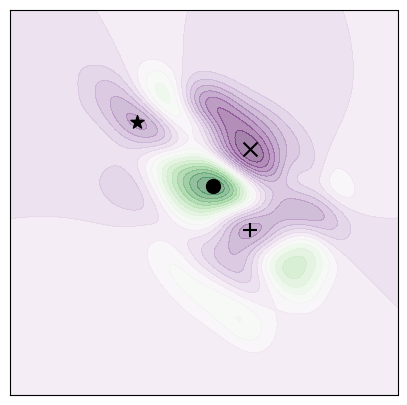

In [3]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

X1 = Z_data_cebra
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)
X = X_scaled

N = 23*36

# Define grid for KDE
# Create a meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
X_grid, Y_grid = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

grid_positions = np.vstack([X_grid.ravel(), Y_grid.ravel()])

X_class0 = X[:N]
X_class1 = X[N:]

# Compute KDE for each class
kde_class0 = gaussian_kde(X_class0.T)
kde_class1 = gaussian_kde(X_class1.T)

# Evaluate KDE on grid
Z_class0 = np.reshape(kde_class0(grid_positions), X_grid.shape)
Z_class1 = np.reshape(kde_class1(grid_positions), X_grid.shape)

def find_kde_peaks(kde_arr):
    '''
    Takes smoothed 2d array kde_arr. Returns sorted local maxima (decreasing).
    '''
    from skimage.feature import peak_local_max
    # Find local maxima
    coordinates = peak_local_max(kde_arr, min_distance=1)
    sort_idx = np.argsort([kde_arr[c[0],c[1]] for c in coordinates])[::-1]
    return coordinates[sort_idx]

n_responders = find_kde_peaks(Z_class1-Z_class0)[0]
responders0 = find_kde_peaks(Z_class0-Z_class1)[0]
responders1 = find_kde_peaks(Z_class0-Z_class1)[1]
responders2 = find_kde_peaks(Z_class0-Z_class1)[2]

n_responder_coords = np.array([X_grid[n_responders[0], n_responders[1]], Y_grid[n_responders[0], n_responders[1]]])
responder_coords0 = np.array([X_grid[responders0[0], responders0[1]], Y_grid[responders0[0], responders0[1]]])
responder_coords1 = np.array([X_grid[responders1[0], responders1[1]], Y_grid[responders1[0], responders1[1]]])
responder_coords2 = np.array([X_grid[responders2[0], responders2[1]], Y_grid[responders2[0], responders2[1]]])

# Plot the KDE contours with peak points
plt.figure(figsize=(5, 5))

plt.contourf(X_grid, Y_grid, Z_class0-Z_class1, levels=20, cmap='PRGn_r', alpha=0.5, origin='image')
plt.scatter(n_responder_coords[0], n_responder_coords[1], color='black', marker='o', s=100)
plt.scatter(responder_coords0[0], responder_coords0[1], color='black', marker='x', s=100)
plt.scatter(responder_coords1[0], responder_coords1[1],color='black', marker='+', s=100)
plt.scatter(responder_coords2[0], responder_coords2[1],color='black', marker='*', s=100)
plt.xticks([])
plt.yticks([])
plt.show()

# Counterfactual Transformation
Apply transformations to shift a non-responder ($\bullet$) towards responders ($+, \times, \star $).

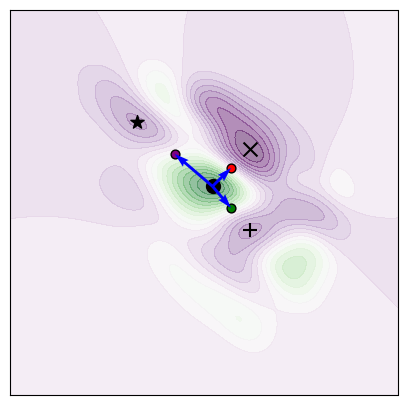

In [4]:
def transform_to_responder(non_responder, responder, alpha=10.0):
    """
    Transforms a non-responder to a responder using the vector direction.
    Args:
        non_responder: Coordinates of the non-responder.
        responder: Coordinates of the responder peak.
        alpha: Scaling factor for the transformation.
    Returns:
        Transformed coordinates.
    """
    vector = responder - non_responder
    return non_responder + alpha * vector

# Example: Transforming a single non-responder to different responders

# Apply the transformation
alpha = 0.5  # Scaling factor
transformed_nonresponder1 = transform_to_responder(n_responder_coords, responder_coords0, alpha)
transformed_nonresponder2 = transform_to_responder(n_responder_coords, responder_coords1, alpha)
transformed_nonresponder3 = transform_to_responder(n_responder_coords, responder_coords2, alpha)

# Visualize transformation
plt.figure(figsize=(5, 5))

plt.contourf(X_grid, Y_grid, Z_class0-Z_class1, levels=20, cmap='PRGn_r', alpha=0.5, origin='image')

plt.scatter(n_responder_coords[0], n_responder_coords[1], color='black', marker='o', s=100)
plt.scatter(responder_coords0[0], responder_coords0[1], color='black', marker='x', s=100)
plt.scatter(responder_coords1[0], responder_coords1[1],color='black', marker='+', s=100)
plt.scatter(responder_coords2[0], responder_coords2[1],color='black', marker='*', s=100)

plt.scatter(transformed_nonresponder1[0], transformed_nonresponder1[1], color='red', edgecolor='k', s=40)
plt.quiver(n_responder_coords[0], n_responder_coords[1],
           transformed_nonresponder1[0] - n_responder_coords[0],
           transformed_nonresponder1[1] - n_responder_coords[1],
           angles='xy', scale_units='xy', scale=1, color='blue')

plt.scatter(transformed_nonresponder2[0], transformed_nonresponder2[1], color='green', edgecolor='k', s=40)
plt.quiver(n_responder_coords[0], n_responder_coords[1],
           transformed_nonresponder2[0] - n_responder_coords[0],
           transformed_nonresponder2[1] - n_responder_coords[1],
           angles='xy', scale_units='xy', scale=1, color='blue')

plt.scatter(transformed_nonresponder3[0], transformed_nonresponder3[1], color='purple', edgecolor='k', s=40)
plt.quiver(n_responder_coords[0], n_responder_coords[1],
           transformed_nonresponder3[0] - n_responder_coords[0],
           transformed_nonresponder3[1] - n_responder_coords[1],
           angles='xy', scale_units='xy', scale=1, color='blue')
#plt.legend()
#plt.title('Transformation of Non-Responder to Responder')
plt.xticks([])
plt.yticks([])
plt.show()


In [5]:
# Transform a non-responder to responders in 5 steps by varying alpha from 0 to 1
steps = 5
alpha_values = np.linspace(0, 1, steps)
tf_nr1_list = []
tf_nr2_list = []
tf_nr3_list = []
for alpha in alpha_values:
    transformed_nonresponder1 = transform_to_responder(n_responder_coords, responder_coords0, alpha)
    transformed_nonresponder2 = transform_to_responder(n_responder_coords, responder_coords1, alpha)
    transformed_nonresponder3 = transform_to_responder(n_responder_coords, responder_coords2, alpha)
    tf_nr1_list.append(scaler.inverse_transform(transformed_nonresponder1.reshape(1,2)))
    tf_nr2_list.append(scaler.inverse_transform(transformed_nonresponder2.reshape(1,2)))
    tf_nr3_list.append(scaler.inverse_transform(transformed_nonresponder3.reshape(1,2)))

tf_nr1 = np.array(tf_nr1_list)
tf_nr2 = np.array(tf_nr2_list)
tf_nr3 = np.array(tf_nr3_list)

# Back-Projection to High-Dimensional latent Space
Transformations in 2D space are projected back into the original high-dimensional DDIM latent space using nearest neighbors.

In [6]:
from sklearn.neighbors import NearestNeighbors

# Using nearest neighbors to project back to high-dimensional space
def find_high_dim_neighbors(z_1, embedded_space, high_dim_space, k=30):
    nbrs = NearestNeighbors(n_neighbors=k).fit(embedded_space)
    distances, indices = nbrs.kneighbors([z_1])  # Ensure z_1 is 2D for input
    weights = 1 / (distances + 1e-5)  # Small value to avoid division by zero
    weights /= weights.sum()  # Normalize weights
    high_dim_neighbors = high_dim_space[indices[0]]
    weighted_avg = np.average(high_dim_neighbors, axis=0, weights=weights[0])
    return weighted_avg, indices[0]

Z_data = latent_data.reshape(n, 4*32*32)
transf1 = []
transf2 = []
transf3 = []
for i in range(5):
    Z_tf1, neighbors_resp = find_high_dim_neighbors(tf_nr1[i,0], Z_data_cebra, Z_data)
    Z_tf2, neighbors_resp = find_high_dim_neighbors(tf_nr2[i,0], Z_data_cebra, Z_data)
    Z_tf3, neighbors_resp = find_high_dim_neighbors(tf_nr3[i,0], Z_data_cebra, Z_data)
    transf1.append(Z_tf1)
    transf2.append(Z_tf2)
    transf3.append(Z_tf3)

transformation1 = np.array(transf1)
transformation2 = np.array(transf2)
transformation3 = np.array(transf3)

In [7]:
# Import libraries
import torch
import torchvision
import numpy as np
import random
import copy
import gc
#import sys
import os
import PIL
from PIL import Image

from models import *

import matplotlib.pyplot as plt
from diffusers import LMSDiscreteScheduler, DDIMScheduler, AutoencoderKL
import timeit
from tqdm.auto import tqdm


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# To the GPU we go!
vae = vae.to(device)

# The noise scheduler
noise_scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
)

niters = 40000
# Load pretrained model
Filename_LDM = 'CcLDM_checkpoint_niters_{}.pth'.format(niters)
print("Loading pre-trained continuous conditional latent diffusion model >>>")
checkpoint = torch.load(Filename_LDM, map_location=device,weights_only=True)
netLDM = cont_cond_unet_diffusion_model().to(device)
netLDM = nn.DataParallel(netLDM)
#netLDM.load_state_dict(checkpoint['netLDM_state_dict'])    
# Adjust checkpoint keys if necessary
checkpoint_state_dict = checkpoint['netLDM_state_dict']
adjusted_state_dict = {}

for key, value in checkpoint_state_dict.items():
    # Replace naming inconsistencies
    new_key = key.replace("query", "to_q").replace("key", "to_k").replace("value", "to_v").replace("proj_attn", "to_out.0")
    adjusted_state_dict[new_key] = value

# Load the adjusted state dict
netLDM.load_state_dict(adjusted_state_dict, strict=True)

Loading pre-trained continuous conditional latent diffusion model >>>


<All keys matched successfully>

In [8]:
labels_ = np.load('84x36_labels.npy')
labels_train = labels_[:n]

# Sample function (regular DDIM) (invert noisy latents back to original latents)
@torch.no_grad()
def sample(start_step=0, start_latents=None, num_inference_steps=30, labels=labels_train, device=device):
  
    # Set num inference steps
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    latents_list = []
    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 32, 32, device=device)
        start_latents *= noise_scheduler.init_noise_sigma

    latents = start_latents.clone()
    timesteps_sample = noise_scheduler.timesteps.long()
    for i in tqdm(range(start_step, num_inference_steps-1)):
    
        #t = noise_scheduler.timesteps[i]
        t = timesteps_sample[i]

        # predict the noise residual
        noise_pred = netLDM.module(latents, t, labels)

        
        prev_t = t-1#max(1, t.item()-1) #max(1, t.item() - (1000//num_inference_steps)) # t-1
        alpha_t = noise_scheduler.alphas_cumprod[t]
        alpha_t_prev = noise_scheduler.alphas_cumprod[prev_t]
        beta_t = 1 - alpha_t
        pred_original_sample = (latents - beta_t ** 0.5 * noise_pred) / alpha_t ** 0.5
        pred_sample_direction = (1 - alpha_t_prev) ** 0.5 * noise_pred
        prev_sample = alpha_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        latents = prev_sample

        # Store
        latents_list.append(latents)
    return latents_list

In [9]:
latents_d1 = torch.tensor(transformation1.reshape(5,4,32,32)).type(torch.float).to(device) 
latents_d2 = torch.tensor(transformation2.reshape(5,4,32,32)).type(torch.float).to(device) 
latents_d3 = torch.tensor(transformation3.reshape(5,4,32,32)).type(torch.float).to(device) 

  0%|          | 0/899 [00:00<?, ?it/s]

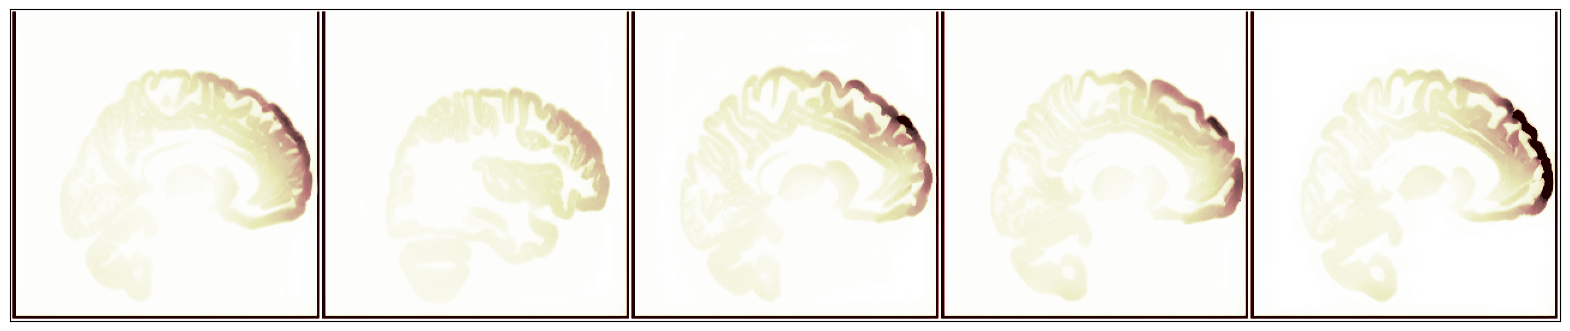

In [10]:
labels_train_90 = labels_train.reshape(46,36)[:,8] # Fix y=90 degree

test_labels = torch.tensor(labels_train_90[:5]).type(torch.float).unsqueeze(-1).to(device)

ddim_latents1 = sample(start_latents=latents_d1, num_inference_steps=900, 
                       labels=test_labels, start_step=0, device=device)

ddim_sample1 = (1 / 0.18215) * ddim_latents1[-1]
with torch.no_grad():
    ddim_sample1 = vae.decode(ddim_sample1).sample 

def cmap_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow=5)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8)).convert("L")
    gamma = 0.8
    grid_im_grey = np.array(grid_im)**gamma
    plt.figure(figsize=(20,5))
    fig = plt.imshow(grid_im_grey, cmap="pink_r",vmax=0.7*np.max(grid_im_grey))
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()
    return fig
cmap_images(ddim_sample1) 

  0%|          | 0/899 [00:00<?, ?it/s]

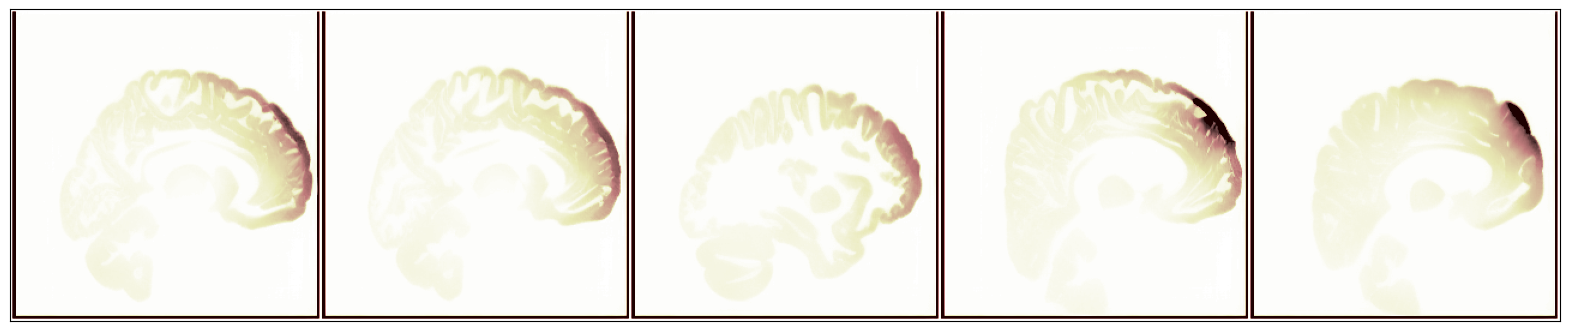

In [11]:
ddim_latents2 = sample(start_latents=latents_d2, num_inference_steps=900, 
                       labels=test_labels, start_step=0, device=device)

ddim_sample2 = (1 / 0.18215) * ddim_latents2[-1]
with torch.no_grad():
    ddim_sample2 = vae.decode(ddim_sample2).sample 
      
cmap_images(ddim_sample2) 

  0%|          | 0/899 [00:00<?, ?it/s]

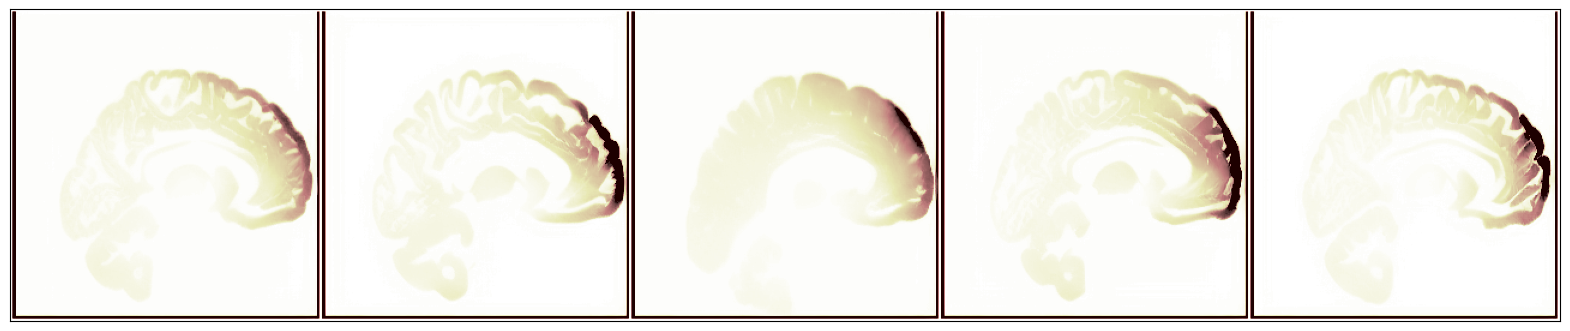

In [12]:
ddim_latents3 = sample(start_latents=latents_d3, num_inference_steps=900, 
                       labels=test_labels, start_step=0, device=device)

ddim_sample3 = (1 / 0.18215) * ddim_latents3[-1]
with torch.no_grad():
    ddim_sample3 = vae.decode(ddim_sample3).sample 
      
cmap_images(ddim_sample3) 

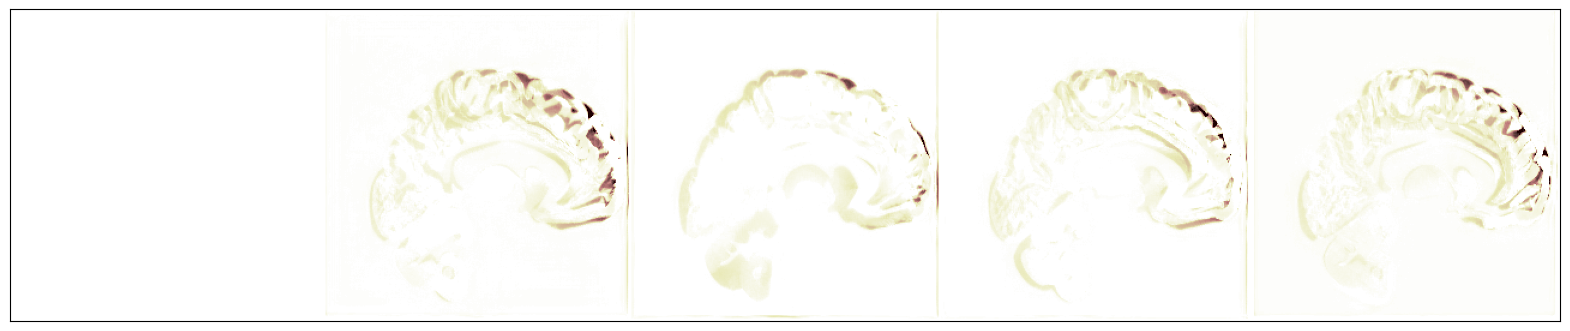

In [13]:
def cmap_res_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    #x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow=5)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8)).convert("L")
    gamma = 0.8
    grid_im_grey = np.array(grid_im)**gamma
    plt.figure(figsize=(20,5))
    fig = plt.imshow(grid_im_grey, cmap="pink_r",vmax=0.7*np.max(grid_im_grey))
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()
    return fig
cmap_res_images(ddim_sample3[0]-ddim_sample3) 